# Read folder from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip data file

In [ ]:
from zipfile import ZipFile
file_name = 'drive/MyDrive/emotion/data.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Importing Libraries

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, MaxPooling2D , AveragePooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras.applications import VGG16, ResNet50, VGG19
from keras.optimizers import Adam
from sklearn.utils import class_weight
from IPython.display import SVG, Image


# EDA

## Displaying Images

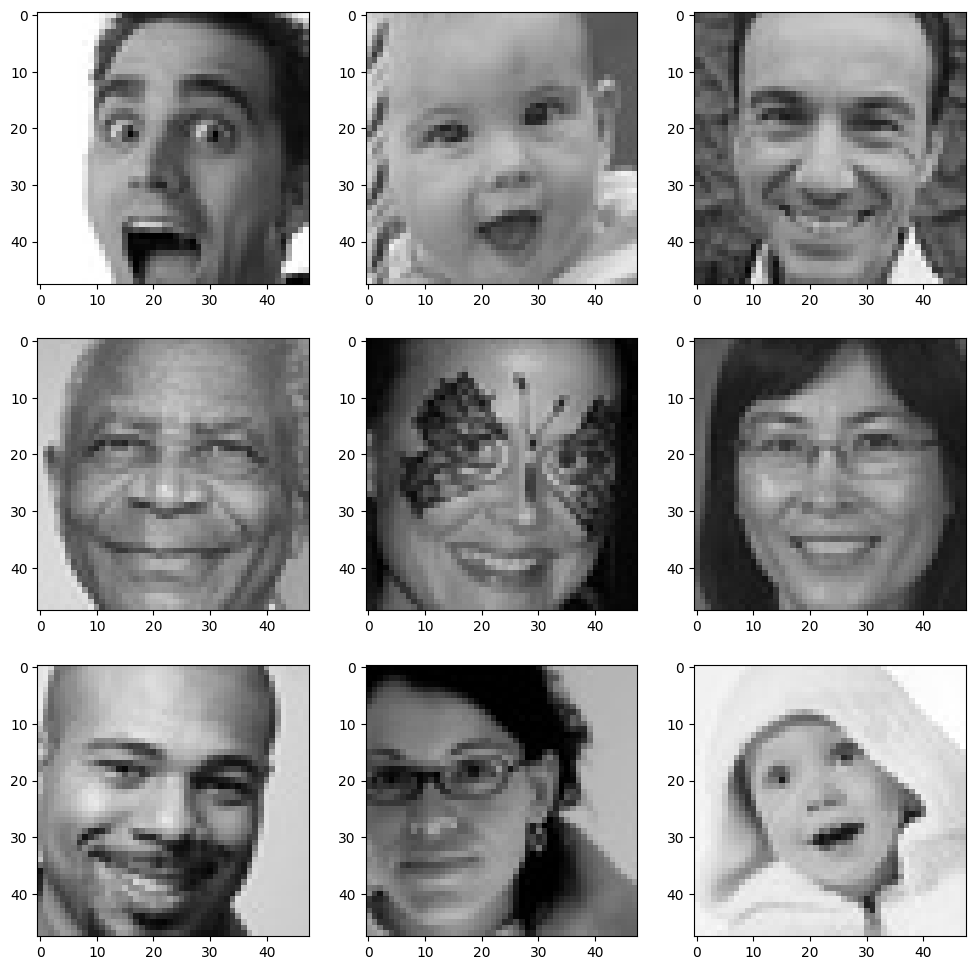

In [ ]:
folder_path = r"data/"
expression = 'happy'
picture_size = 48

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size)
                  )
    plt.imshow(img)
plt.show()

## The number of images in each class.

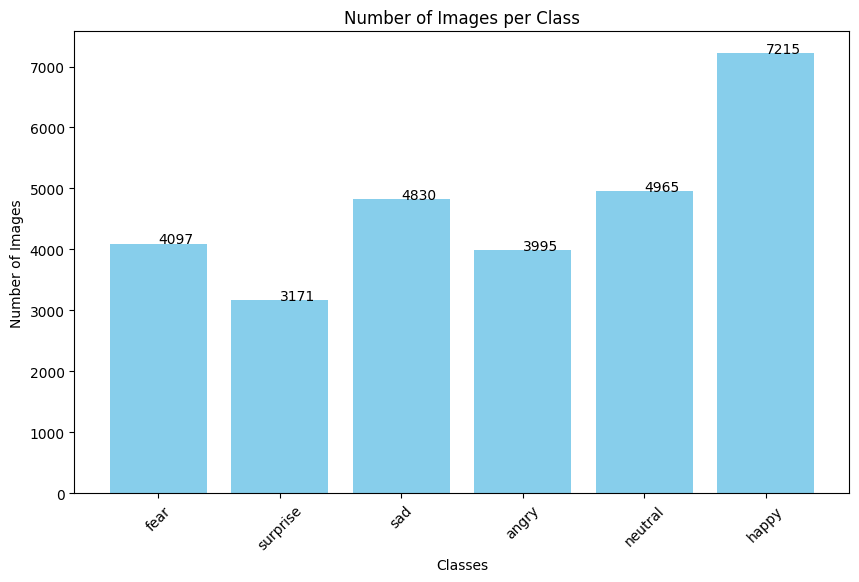

In [ ]:
classes = os.listdir(folder_path + "train/")
class_counts = {cls: len(os.listdir(folder_path + "train/" + cls)) for cls in classes}
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval))
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()

# Training and Validation Data

In [ ]:
# Define data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define preprocessing for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    folder_path+"train",
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    folder_path+"test",
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

# Assuming y_train is available from your training generator
y_train = train_generator.classes

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


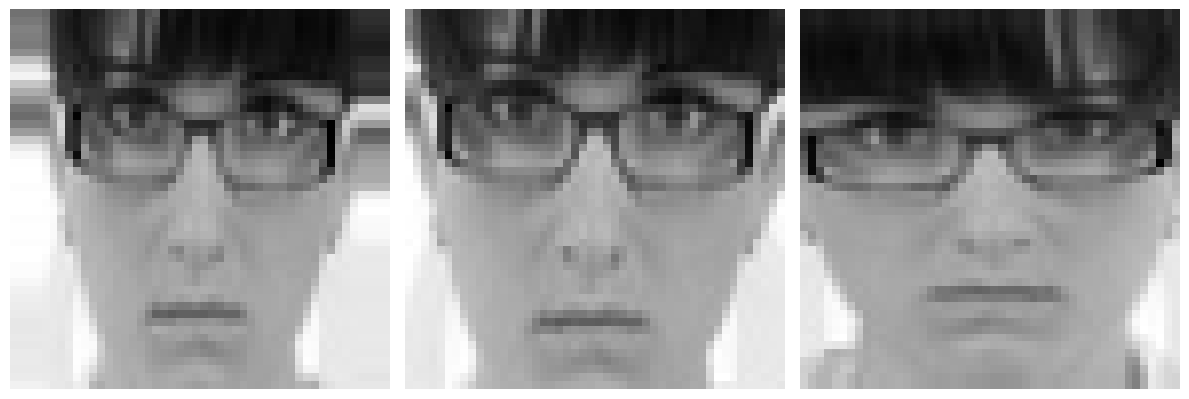

In [ ]:
# Visualize augmented images
img_path = os.path.join(folder_path, "train", classes[0], os.listdir(os.path.join(folder_path, "train", classes[0]))[0])
img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

augmented_images = train_datagen.flow(img_array, batch_size=1)

plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 3, i+1)
    batch = augmented_images.next()
    img_augmented = batch[0]
    plt.imshow(img_augmented.squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Building

## Model from Scratch

### Model Architecture

In [ ]:
model= Sequential()

# 1st conv
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd conv
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# 3rd conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4th conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten
model.add(Flatten())

# 1st dense layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd dense layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#output layer
model.add(Dense(6, activation='softmax'))


### Compile the Model

In [ ]:
opt= Adam(learning_rate=0.0005)
model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### Train the Model

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/100
883/883 [==============================] - 32s 26ms/step - loss: 1.8082 - accuracy: 0.2713 - val_loss: 1.6187 - val_accuracy: 0.3415
Epoch 2/100
883/883 [==============================] - 22s 25ms/step - loss: 1.5369 - accuracy: 0.3938 - val_loss: 1.3703 - val_accuracy: 0.4625
Epoch 3/100
883/883 [==============================] - 22s 25ms/step - loss: 1.3891 - accuracy: 0.4595 - val_loss: 1.2240 - val_accuracy: 0.5189
Epoch 4/100
883/883 [==============================] - 22s 25ms/step - loss: 1.3069 - accuracy: 0.4948 - val_loss: 1.1728 - val_accuracy: 0.5430
Epoch 5/100
883/883 [==============================] - 22s 25ms/step - loss: 1.2576 - accuracy: 0.5183 - val_loss: 1.1711 - val_accuracy: 0.5511
Epoch 6/100
883/883 [==============================] - 22s 25ms/step - loss: 1.2293 - accuracy: 0.5316 - val_loss: 1.2066 - val_accuracy: 0.5287
Epoch 7/100
883/883 [==============================] - 22s 25ms/step - loss: 1.1979 - accuracy: 0.5431 - val_loss: 1.1164 - val_ac

### Plotting Accuracy & Loss

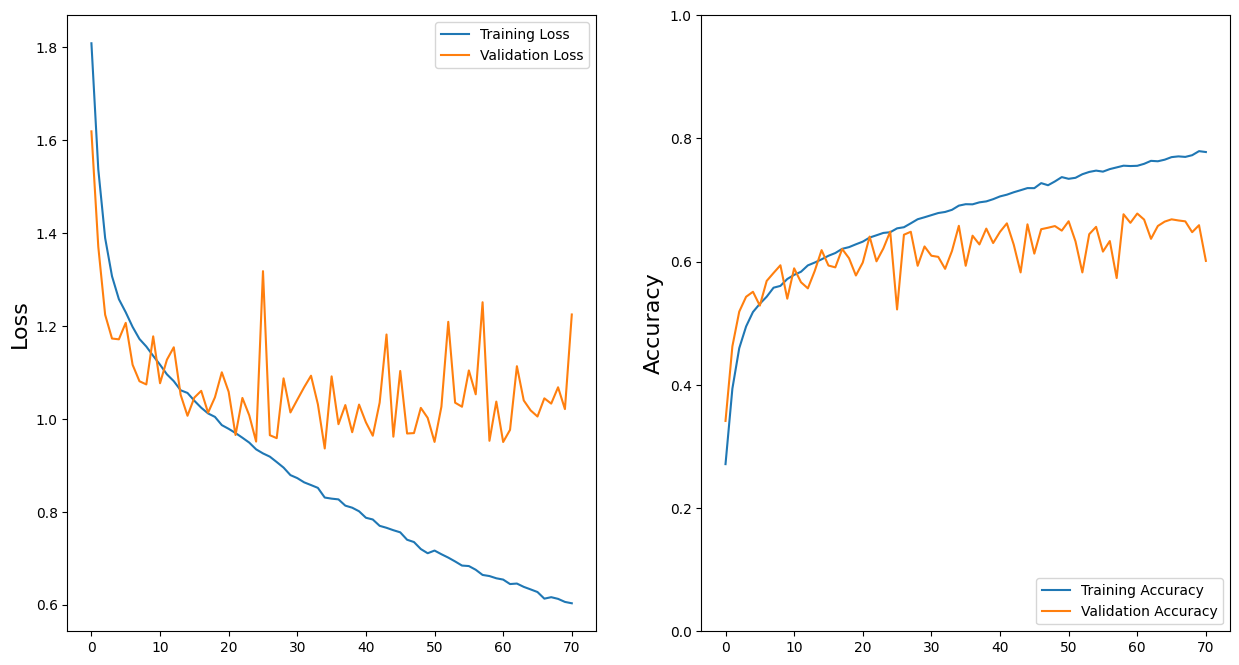

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.show()

### Evaluate the Model

In [ ]:
test_loss, test_acc = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f"Validation accuracy: {test_acc}")

220/220 [==============================] - 2s 11ms/step - loss: 0.9549 - accuracy: 0.6776
Validation accuracy: 0.6775568127632141


### Make Predictions

1/1 [==============================] - 0s 23ms/step


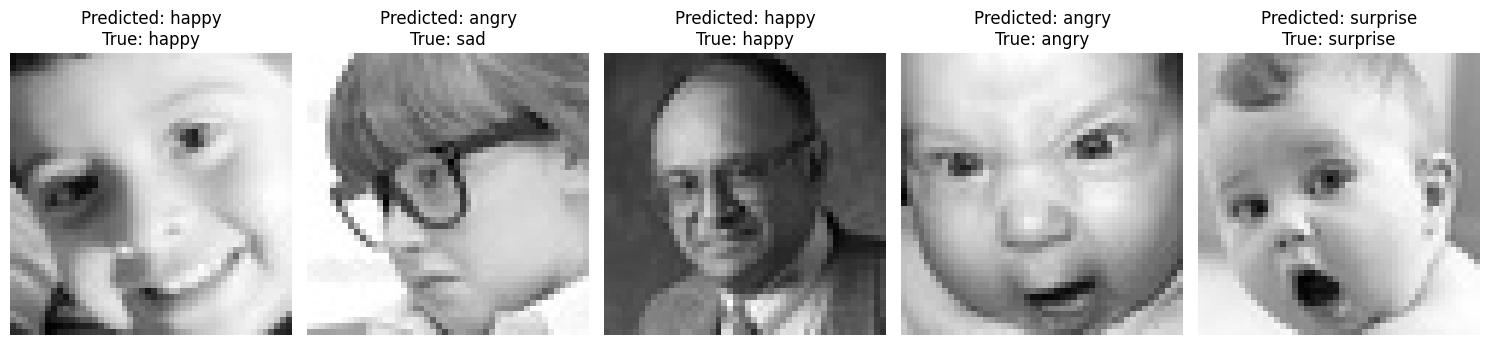

In [ ]:
val_images, val_labels = next(val_generator)

# Select 5 images
selected_images = val_images[:5]
selected_labels = val_labels[:5]

# Make predictions
predictions = model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(selected_labels, axis=1)
class_labels = list(val_generator.class_indices.keys())

# Print the predicted and true labels for each image
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i].reshape(48, 48), cmap='gray')
    ax.set_title(f"Predicted: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_classes[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Save Model

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Load Model

In [ ]:
#model = tf.keras.models.load_model('my_model.h5')

# Pre-trained Models

## VGG16

In [ ]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(48, 48, 3)))

# Convert grayscale to RGB
input_layer = Input(shape=(48, 48, 1))
x = Conv2D(3, (1, 1))(input_layer)

x = base_model(x)
x = GlobalAveragePooling2D()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

output_layer = Dense(6, activation='softmax')(x)

vgg_model = Model(inputs=input_layer, outputs=output_layer)

vgg_model.summary()

# fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True )

# training
history_VGG = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 3)         6         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512    

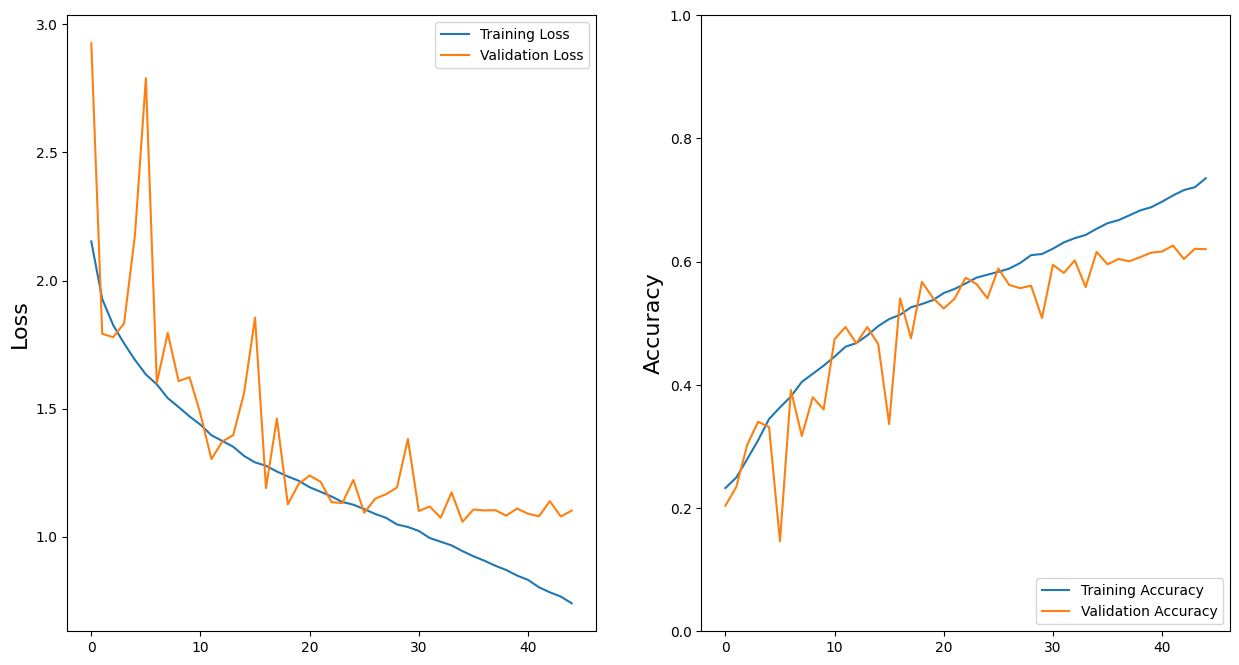

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_VGG.history['loss'], label='Training Loss')
plt.plot(history_VGG.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_VGG.history['accuracy'], label='Training Accuracy')
plt.plot(history_VGG.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.show()

In [ ]:
model.save('VGG16_model.h5')

In [ ]:
test_loss, test_acc = vgg_model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f"Validation accuracy: {test_acc}")

220/220 [==============================] - 2s 10ms/step - loss: 1.3434 - accuracy: 0.6438
Validation accuracy: 0.643750011920929


1/1 [==============================] - 0s 26ms/step


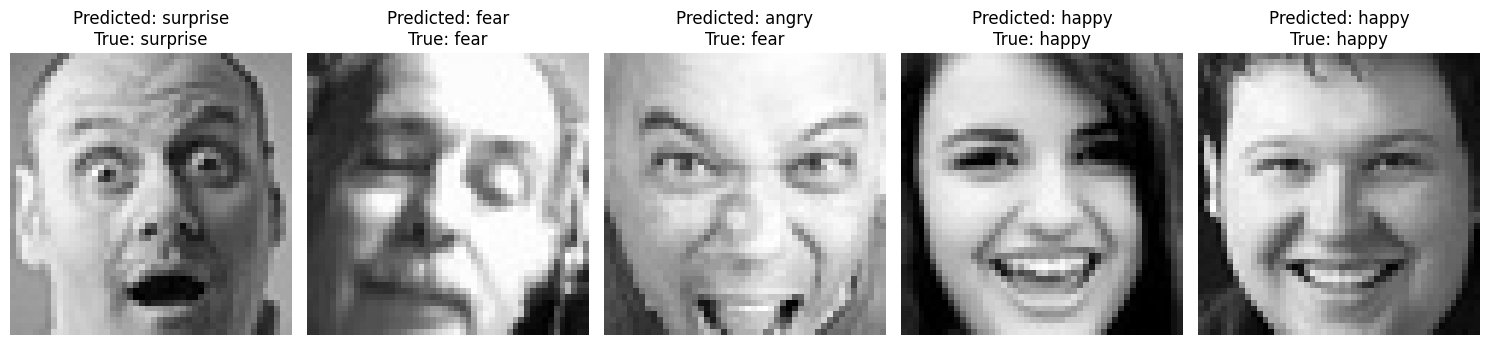

In [ ]:
# Make predictions
predictions = vgg_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(selected_labels, axis=1)
class_labels = list(val_generator.class_indices.keys())

# Print the predicted and true labels for each image in the same row
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i].reshape(48, 48), cmap='gray')
    ax.set_title(f"Predicted: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_classes[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## ResNet50

In [ ]:
# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(48, 48, 3)))

input_layer = Input(shape=(48, 48, 1))
x = Conv2D(3, (1, 1))(input_layer)

x = base_model(x)
x = GlobalAveragePooling2D()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

output_layer = Dense(6, activation='softmax')(x)

resnet50_model = Model(inputs=input_layer, outputs=output_layer)

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile
resnet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_model.summary()

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Training
history_resnet50 = resnet50_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 3)         6         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512  

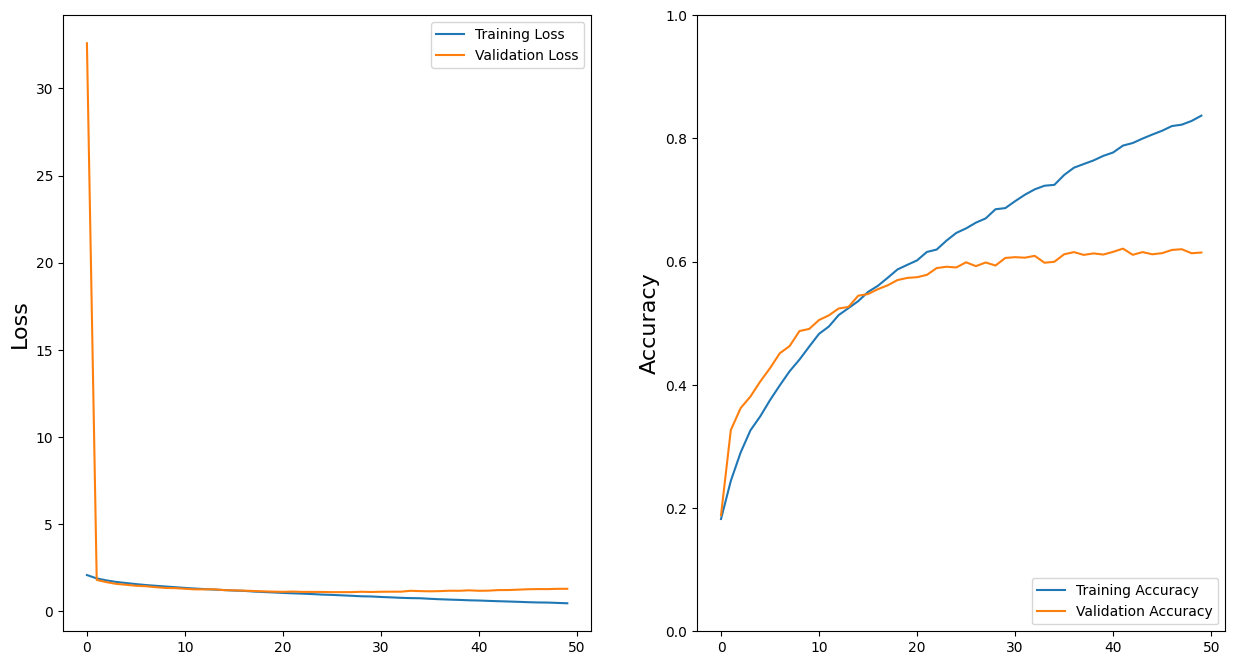

In [ ]:
# Plot Accuracy & Loss
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Save model
model.save('ResNet50_model.h5')

In [ ]:
# Evaluate model
test_loss, test_acc = resnet50_model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f"Validation accuracy: {test_acc}")

220/220 [==============================] - 3s 11ms/step - loss: 1.2924 - accuracy: 0.6148
Validation accuracy: 0.6147727370262146


1/1 [==============================] - 0s 28ms/step


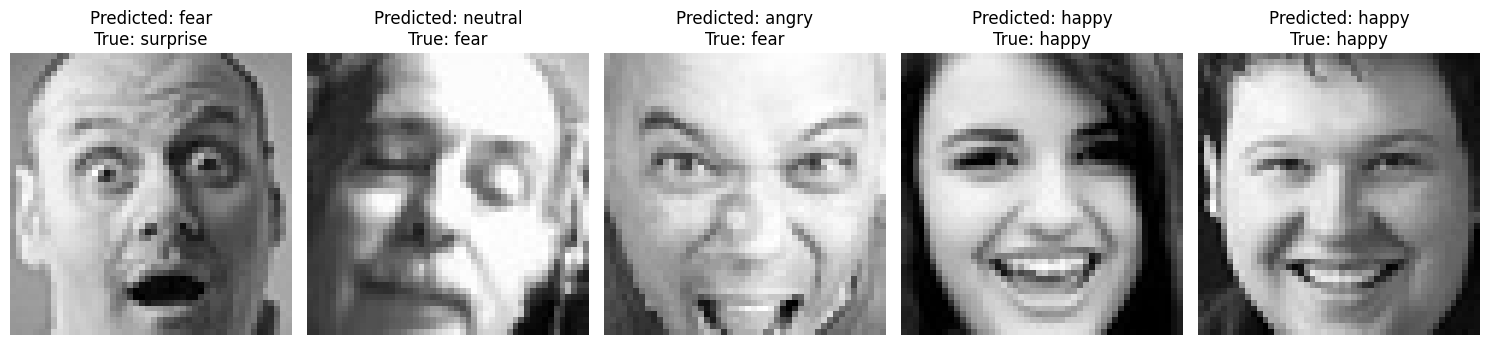

In [ ]:
# Make predictions
predictions = resnet50_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(selected_labels, axis=1)
class_labels = list(val_generator.class_indices.keys())

# Print the predicted and true labels for each image
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i].reshape(48, 48), cmap='gray')
    ax.set_title(f"Predicted: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_classes[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()